In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import glob
%matplotlib inline

In [16]:
# Create and test the video sequence for the Car4 dataset

vid_seq = []

# Iterate through all the images with .jpg extension
for file in glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Car4\\img\\*.jpg'):
    
    #Read the images sequentially and append them in the vid_seq list
    img = cv2.imread(file)
    height, width, layers = img.shape
    size = (width,height)
    vid_seq.append(img)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('Car.avi',fourcc,5.0,size)

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

In [17]:
# Create and test the video sequence for the Bolt dataset

vid_seq = []

# Iterate through all the images with .jpg extension
for file in glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Bolt2\\img\\*.jpg'):
    
    # Read the images sequentially and append them in the vid_seq list
    img = cv2.imread(file)
    height, width, layers = img.shape
    size = (width,height)
    vid_seq.append(img)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('Bolt.avi',fourcc,5.0,size)

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

In [17]:
# Create and test the video sequence for the BabyDragon dataset

vid_seq = []

# Iterate through all the images with .jpg extension
for file in glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\DragonBaby\\img\\*.jpg'):
    
    # Read the images sequentially and append them in the vid_seq list
    img = cv2.imread(file)
    height, width, layers = img.shape
    size = (width,height)
    vid_seq.append(img)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('DragonBaby.avi',fourcc,20.0,size)

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

## Implementation of the Lucas Kanade metod for Affine Warp

Warp the image $I$ to obtain $I(W[x,y];P)$

Compute the error image $T(x)-I(W[x,y];P)$

Warp the Gradient ${\nabla{I}}$ with $(W[x,y];P)$

Evaluate $\frac{\partial W}{\partial P}$ at $([x,y];P)$

Compute Steepest descent images ${\nabla{I}}\frac{\partial W}{\partial P}$

Compute the Hessian Matrix $\sum{({\nabla{I}}\frac{\partial W}{\partial P})}^{T}{{\nabla{I}}\frac{\partial W}{\partial P}}$

Compute $\sum{({\nabla{I}}\frac{\partial W}{\partial P})}{(T(x)-I(W[x,y];P))}$

Compute ${\Delta P}$

$P{\leftarrow}P+{\Delta P}$

Keep Iterating till the magnitude of ${\Delta P}$ is negligible

And also ${\Delta P} = {({A}^{T}{A}})^{-1}{A^{T}}{b}$

Here ${{A}^{T}{A}}$ is the Hessian Matrix that has been computed above and $A$ is the steepest descent image and $b$ is basicallty the error image that has been computed in step 2

Affine Transform is given as ${\begin{bmatrix} 1+{p_1} & {p_3} & {p_5}\\ {p_2} & {1+{p_4}} & {p_{6}}\\0&0&1\\\end{bmatrix}}$

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform
import glob
%matplotlib inline

# Get a grayscale image to input in the Lucas Kanade 
def get_grayscale_image(image):
    
    """
    Inputs:
    path_to_frame: The path to the frame that needs to be converted to a grayscale image: dtype=string
    
    """
    grayscale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    grayscale = cv2.GaussianBlur(grayscale, (3, 3),5)  
    return grayscale

# Reference: CMU Graduate computer Vision Course
def crop_warped(image,rect):
    
    """
    Inputs:
    image: The warped image after performing an affine transformation
    rect: The upleft and the truth bounding box
    
    """
    #warped = image[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
    warped = image[rect[1]:rect[3], rect[0]:rect[2]]
    return warped
    
def LucasKanadeAffine(image,template,rect,p,threshold, iterations):
    
    """
    Inputs:
    
    image: The input gray scale image
    template: The template image
    rect: The top left coordinates and the bottom right coordinates of the rectangle format--> [x1,y1,x2,y2]
    threshold: The threshold that has been set to terminate the iterations as soon as delta p value approaches the threshold value
    parameters: The initial parameters of the affine warp
    iterations: Number of times the algorithm needs to run
    
    Returns:
    p: Paramters of the affine warp matrix
    Upper left bounding bax coordinates
    Downright bounding box coordinates
    """
    # Crop the region of interest from the template frame
    template = crop_warped(template,rect)
    
    # Parameters of the affine matrix
    #p = np.array([parameters]).reshape(-1,1)
    
    # Threshold for convergence
    thresh = threshold
    
    # Initial Affine Matrix
    #affine_matrix = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0]])
    
    #I = affine_matrix
    
    for iteration in range(iterations):
        
        # affine matrix
        affine_matrix = np.array([[1 + p[0][0], p[2][0], p[4][0]], [p[1][0], 1 + p[3][0], p[5][0]]], dtype = np.float32)
        
        # Warp the input image
        warped_image = cv2.warpAffine(image, affine_matrix, (0, 0), flags=cv2.INTER_CUBIC + cv2.WARP_INVERSE_MAP)
        
        # Compute the error image
        error_image = template - crop_warped(warped_image, rect)
        
        # Compute the image gradient in the x direction
        sobelx = cv2.Sobel(image, cv2.CV_64F, dx = 1, dy = 0, ksize = 5)
        
        # Compute the warped gradient in the x direction
        sobel_x_warped = cv2.warpAffine(sobelx, affine_matrix, (0, 0), flags=cv2.INTER_CUBIC + cv2.WARP_INVERSE_MAP)
        
        # Crop the Region of interest in our image gradient
        sobel_x_cropped = crop_warped(sobel_x_warped, rect)
        
        # Compute the image gradient in the y direction
        sobely = cv2.Sobel(image, cv2.CV_64F, dx = 0, dy = 1, ksize = 5)
        
        # Compute the warped gradient in the y direction
        sobel_y_warped = cv2.warpAffine(sobely, affine_matrix, (0, 0), flags=cv2.INTER_CUBIC + cv2.WARP_INVERSE_MAP)
        
        # Crop the Region of interest in our image gradient
        sobel_y_cropped = crop_warped(sobel_y_warped, rect)
        
        # Flatten out the warped gradients
        sobel_x_warped = sobel_x_warped.reshape(-1,1)
        sobel_y_warped = sobel_y_warped.reshape(-1,1)
        
        # Warp the image gradient with the warping function to produce an mx2 matrix
        # Horizontally stack the derivatives
        gradient_image_warped = np.hstack((sobel_x_warped,sobel_y_warped))
        
        # Evaluate the Jacobian and the steepest descent 
        count = 0
        steepest_descent = []
        for y in range(rect[1],rect[3]):
            for x in range(rect[0],rect[2]):
                
                Jacobian = [x*sobel_x_warped[count][0], x*sobel_y_warped[count][0], y*sobel_x_warped[count][0], y*sobel_y_warped[count][0], sobel_x_warped[count][0], sobel_y_warped[count][0]]
                steepest_descent.append(Jacobian)
                count = count + 1
        steepest_descent = np.array(steepest_descent)
        
        # Calculate the Hessian and inverse hessian from the steepest descent
        sd_params_update = np.dot(steepest_descent.T,error_image.reshape(-1,1))
        hessian = np.dot(steepest_descent.T,steepest_descent)
        hessian_inverse = np.linalg.pinv(hessian)
        
        # Update delta p using solution for least squares
        delta_p = np.dot(hessian_inverse, sd_params_update)
        
        # Update the parameters p
        p = np.reshape(p, (6, 1))
        p = p + 0.05*delta_p
        #print(f'After Iteration: {iterations} Value of p: {p}')
        
        # Update the affine matrix with the newly generated parameters
        #affine_matrix = p.reshape(2,3) + I
        
        # Convergence test
        if np.linalg.norm(delta_p) <= thresh:
            break
            
    # Updated affine matrix
    affine_matrix = np.array([[1 + p[0][0], p[2][0], p[4][0]], [p[1][0], 1 + p[3][0], p[5][0]]], dtype = np.float32)
    top_left_coordinates = np.array([[rect[0]],[rect[1]],[1]])
    bottom_right_coordinates = np.array([[rect[2]], [rect[3]], [1]])
    updated_top_left_coordinates = np.dot(affine_matrix, top_left_coordinates)
    updated_bottom_right_coordinates = np.dot(affine_matrix, bottom_right_coordinates)
    
    print(f'top_left: {updated_top_left_coordinates} \tbottom_right:{updated_bottom_right_coordinates}')
    return p, updated_top_left_coordinates, updated_bottom_right_coordinates


In [14]:
rect_car = np.array([70,51,107+70,87+51])
rect_bolt = np.array([269,75,34+269,64+75])
rect_baby = np.array([160,83,56+160,65+83])

# Create and test the video sequence for the Bolt dataset

files  = glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Bolt2\\img\\*.jpg')

# grayscale template image
template = cv2.imread(files[0])
grayscale_template = get_grayscale_image(template)

# List to append the frame sequences
vid_seq = []

p = np.array([[0., 0, 0, 0, 0, 0]]).T

# Iterate through all the images with .jpg extension
for file in files:
    
    image = cv2.imread(file)
    image_copy = image.copy()
    
    # Input the gray scale image
    grayscale_image = get_grayscale_image(image_copy)
    
    # Run the Lucas Kanade Algorithm
    p, top_left_coordinates, bottom_right_coordinates = LucasKanadeAffine(grayscale_image,grayscale_template,rect_bolt, p,threshold = 0.001, iterations = 31)
    
    # Create a bounding box
    image = cv2.rectangle(image,(int(top_left_coordinates[0][0]),int(top_left_coordinates[1][0])), (int(bottom_right_coordinates[0][0]), int(bottom_right_coordinates[1][0])), (0, 0, 255), 2)
    
    vid_seq.append(image)

# The fourcc code
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Video writer object
out = cv2.VideoWriter('Bolt.avi',fourcc,20.0, (480, 270))

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

top_left: [[269.]
 [ 75.]] 	bottom_right:[[303.]
 [139.]]
top_left: [[268.99801889]
 [ 74.90525918]] 	bottom_right:[[302.99748211]
 [138.90086225]]
top_left: [[268.99515739]
 [ 74.56688375]] 	bottom_right:[[303.00727729]
 [138.95320066]]
top_left: [[269.02294023]
 [ 74.59057112]] 	bottom_right:[[303.00138849]
 [138.97904378]]
top_left: [[268.99748737]
 [ 74.67192496]] 	bottom_right:[[303.01696586]
 [139.13245184]]
top_left: [[268.9707842 ]
 [ 74.64540737]] 	bottom_right:[[303.02593084]
 [139.23037984]]
top_left: [[268.96268452]
 [ 74.75735333]] 	bottom_right:[[303.05377514]
 [139.02820357]]
top_left: [[268.96715567]
 [ 74.69565618]] 	bottom_right:[[303.07219833]
 [138.91457107]]
top_left: [[268.89743519]
 [ 74.60672593]] 	bottom_right:[[303.15332001]
 [138.82269704]]
top_left: [[268.88169711]
 [ 74.65558347]] 	bottom_right:[[303.20174324]
 [138.91064477]]
top_left: [[268.87250924]
 [ 74.81830144]] 	bottom_right:[[303.17336347]
 [138.92402729]]
top_left: [[268.91060641]
 [ 74.93567859]]

top_left: [[269.87951497]
 [ 75.49395178]] 	bottom_right:[[303.43196103]
 [138.50529336]]
top_left: [[269.91182908]
 [ 75.64989453]] 	bottom_right:[[303.4509579 ]
 [138.49598479]]
top_left: [[269.91305573]
 [ 75.66059782]] 	bottom_right:[[303.46812738]
 [138.44321909]]
top_left: [[269.98647619]
 [ 75.56929557]] 	bottom_right:[[303.35274482]
 [138.44507952]]
top_left: [[269.95386715]
 [ 75.54972706]] 	bottom_right:[[303.40748689]
 [138.49269918]]
top_left: [[269.9800709 ]
 [ 75.67758124]] 	bottom_right:[[303.37934929]
 [138.37211619]]
top_left: [[270.01282043]
 [ 75.62263899]] 	bottom_right:[[303.37339204]
 [138.31210841]]
top_left: [[269.97667623]
 [ 75.44539399]] 	bottom_right:[[303.44127022]
 [138.36756657]]
top_left: [[270.01798015]
 [ 75.29514165]] 	bottom_right:[[303.42168457]
 [138.48928418]]
top_left: [[270.13712194]
 [ 75.3487516 ]] 	bottom_right:[[303.30045161]
 [138.62399365]]
top_left: [[270.01531634]
 [ 75.5632501 ]] 	bottom_right:[[303.39357917]
 [138.64842058]]
top_left: 

top_left: [[270.61397224]
 [ 75.56272275]] 	bottom_right:[[304.52676815]
 [139.82460636]]
top_left: [[270.60087584]
 [ 75.31368024]] 	bottom_right:[[304.50051044]
 [139.7863889 ]]
top_left: [[270.60401576]
 [ 75.10766006]] 	bottom_right:[[304.49405949]
 [139.93135524]]
top_left: [[270.61525639]
 [ 75.1226376 ]] 	bottom_right:[[304.50441202]
 [140.11611266]]
top_left: [[270.60774818]
 [ 75.33827525]] 	bottom_right:[[304.49386183]
 [140.01497708]]
top_left: [[270.59162201]
 [ 75.33540704]] 	bottom_right:[[304.60718979]
 [139.92645979]]
top_left: [[270.57790613]
 [ 75.19763176]] 	bottom_right:[[304.6410104 ]
 [139.92324215]]
top_left: [[270.53100371]
 [ 75.23993154]] 	bottom_right:[[304.63399946]
 [139.79794135]]
top_left: [[270.5578477 ]
 [ 75.32109484]] 	bottom_right:[[304.61360105]
 [139.64676939]]
top_left: [[270.61111265]
 [ 75.28229486]] 	bottom_right:[[304.6240837 ]
 [139.56376969]]
top_left: [[270.63120522]
 [ 75.20123232]] 	bottom_right:[[304.62480201]
 [139.52619724]]
top_left: 

 [119.69875868]]
top_left: [[273.77551357]
 [217.42778707]] 	bottom_right:[[306.78531305]
 [119.69875868]]
top_left: [[273.77551357]
 [217.42778707]] 	bottom_right:[[306.78531305]
 [119.69875868]]
top_left: [[273.77551357]
 [217.42778707]] 	bottom_right:[[306.78531305]
 [119.69875868]]
top_left: [[273.77551357]
 [217.42778707]] 	bottom_right:[[306.78531305]
 [119.69875868]]
top_left: [[273.77551357]
 [217.42778707]] 	bottom_right:[[306.78531305]
 [119.69875868]]
top_left: [[273.77551357]
 [217.42778707]] 	bottom_right:[[306.78531305]
 [119.69875868]]
top_left: [[273.77551357]
 [217.42778707]] 	bottom_right:[[306.78531305]
 [119.69875868]]
top_left: [[273.77551357]
 [217.42778707]] 	bottom_right:[[306.78531305]
 [119.69875868]]
top_left: [[273.77551357]
 [217.42778707]] 	bottom_right:[[306.78531305]
 [119.69875868]]
top_left: [[273.77551357]
 [217.42778707]] 	bottom_right:[[306.78531305]
 [119.69875868]]
top_left: [[273.77551357]
 [217.42778707]] 	bottom_right:[[306.78531305]
 [119.6987

64

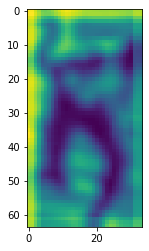

In [19]:
frame1 = cv2.imread('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Bolt2\\img\\0001.jpg',0)
frame2 = cv2.imread('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Car4\\img\\0001.jpg',0)
frame3 = cv2.imread('C:\\Users\\shant\\lucas_kanade_tracker\\data\\DragonBaby\\img\\0001.jpg',0)

rect_car = [70,51,107+70,87+51]
rect_bolt = np.array([269,75,34+269,64+75])
rect_baby = np.array([160,83,56+160,65+83])

frame1_copy = frame1.copy()
frame1_copy = cv2.rectangle(frame1_copy,(rect_bolt[0],rect_bolt[1]),(rect_bolt[2],rect_bolt[3]),color = (255,0,0),thickness = 2)
template = frame1_copy[rect_bolt[1]:rect_bolt[3],rect_bolt[0]:rect_bolt[2]]
template = cv2.GaussianBlur(template, (5, 5), 5)
cv2.imshow('frame 2', frame1_copy)
plt.imshow(template)
frame1.shape
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
template.shape[0]

In [21]:
frame1 = cv2.imread('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Bolt2\\img\\0001.jpg',0)
frame1.shape

(270, 480)

In [ ]:
# The inverse Compositional algorithm for brightness adjustment
def LucasKanadeInverseCompositional():
    
    """
    Inputs:
    
    template: The input template image
    image: The input image
    threshold: The threshold for convergence 
    
    """